In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, get_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import pennylane_PQC_RZRXRZ_unique, qiskit_PQC_RZRXRZ_unique, qiskit_PQC_RXRZ_unique

from simulator.simulate import get_ideal_data_state, get_ideal_data_superpos
from models.pennylane_models import SimplePennylaneQuantumStateModel
from models.noise_models import BitPhaseFlipNoise
from circuits.generate_circuits import GetGHZCircuitsForModel
from utils.loss_functions import QuantumFidelityLoss

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 3
INPUT_BITS = '10101'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
# fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
# noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)
pqc_arch = pennylane_PQC_RZRXRZ_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = SimplePennylaneQuantumStateModel(
    num_qubits= NUM_QUBITS, num_params=NUM_QUBITS*3, pqc_arch_func=pqc_arch,   
    )

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
    )



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.05)
loss_fn = QuantumFidelityLoss()
# loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_state(NUM_QUBITS, num_vals=int(10000))
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:11<00:00, 881.50it/s]

32


In [9]:
param_list_epoch = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []
    epoch_param_snapshots = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        circuit = ghz_circuit_gen.get_noisy_model_circuit_params(params)
        measured = pqc_model(circuit=circuit)

        ideal = ideal.to(torch_device)
        measured = measured.to(torch_device)

        # print(ideal)
        # print(measured)

        # Compute fidelity loss
        # print(ideal)
        # print(measured)
        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out

        loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        epoch_param_snapshots.append(raw_param_values)
        epoch_loss_list.append(loss.item())

        data_iterator.set_postfix_str(f"Loss: {loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            # bounded = pqc_model.raw_params.detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            # print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")

# Optional: print debug stats
        if enable_debug_logs and step == len(data_iterator) - 1:
            print(circuit.draw())
            print(measured)
            print(ideal)
            print(loss)

    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)
    param_list_epoch.extend(np.array(epoch_param_snapshots))

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

        


 Starting Epoch 1


  0%|          | 10/10000 [00:00<06:08, 27.15it/s, Loss: 9.9640e-01] 

	Step 0, grad norm: 2.3729e-02
	Raw param range: [-12.983, 10.736]


100%|█████████▉| 9995/10000 [02:41<00:00, 46.53it/s, Loss: 9.7867e-01]

     ┌────────────┐┌────────────┐                                            »
q_0: ┤ Rx(1.0406) ├┤ Rz(1.0396) ├────────────────────────────────────────────»
     ├────────────┤├────────────┤                                            »
q_1: ┤ Rx(4.8982) ├┤ Rz(1.9918) ├────────────────────────────────────────────»
     ├───────────┬┘├────────────┤                                            »
q_2: ┤ Rx(5.008) ├─┤ Rz(1.9703) ├────────────────────────────────────────────»
     ├───────────┤ ├────────────┤┌───┐┌─────────────────┐┌──────────────────┐»
q_3: ┤ Rx(2.001) ├─┤ Rz(3.6256) ├┤ H ├┤ z_noise(0.1015) ├┤ x_noise(0.10748) ├»
     ├───────────┴┐├────────────┤└───┘└─────────────────┘└──────────────────┘»
q_4: ┤ Rx(3.2706) ├┤ Rz(3.3518) ├────────────────────────────────────────────»
     └────────────┘└────────────┘                                            »
«     ┌───┐┌──────────────────┐┌──────────────────┐                         »
«q_0: ┤ X ├┤ z_noise(0.10516) ├┤ x_noise(0.10374) ├──

100%|██████████| 10000/10000 [02:41<00:00, 61.95it/s, Loss: 9.7867e-01]


tensor([-0.0179-0.0054j, -0.1396+0.2532j,  0.0204-0.0208j, -0.2481-0.3763j,
         0.0106+0.0088j,  0.1682-0.1326j, -0.0199+0.0083j,  0.0609+0.3283j,
         0.0117+0.0102j,  0.1915-0.1444j, -0.0225+0.0088j,  0.0603+0.3690j,
        -0.0051-0.0103j, -0.1723+0.0433j,  0.0179+0.0005j,  0.0652-0.2692j,
        -0.0104+0.0025j,  0.0045+0.1656j,  0.0041-0.0162j, -0.2318-0.1139j,
         0.0078+0.0013j,  0.0446-0.1143j, -0.0074+0.0099j,  0.1254+0.1445j,
         0.0087+0.0016j,  0.0527-0.1269j, -0.0086+0.0109j,  0.1369+0.1648j,
        -0.0055-0.0036j, -0.0725+0.0714j,  0.0090-0.0050j, -0.0459-0.1519j],
       device='cuda:0', dtype=torch.complex128)
tensor(0.9787, device='cuda:0', dtype=torch.float64, grad_fn=<RsubBackward1>)
Epoch 1 complete: avg loss = 8.9090e-01

 Starting Epoch 2


  0%|          | 5/10000 [00:00<03:52, 43.00it/s, Loss: 9.1024e-01]

	Step 0, grad norm: 1.0993e-02
	Raw param range: [-3.599, 7.051]


100%|██████████| 10000/10000 [02:54<00:00, 57.21it/s, Loss: 9.9308e-01]


     ┌────────────┐┌───────────┐                                              »
q_0: ┤ Rx(1.3615) ├┤ Rz(2.224) ├──────────────────────────────────────────────»
     ├───────────┬┘├───────────┴┐                                             »
q_1: ┤ Rx(3.145) ├─┤ Rz(2.3304) ├─────────────────────────────────────────────»
     ├───────────┴┐├────────────┤                                             »
q_2: ┤ Rx(4.1869) ├┤ Rz(2.5125) ├─────────────────────────────────────────────»
     ├────────────┤├───────────┬┘┌───┐┌───────────────────┐┌─────────────────┐»
q_3: ┤ Rx(5.2038) ├┤ Rz(1.182) ├─┤ H ├┤ z_noise(0.099879) ├┤ x_noise(0.1026) ├»
     ├────────────┤├───────────┤ └───┘└───────────────────┘└─────────────────┘»
q_4: ┤ Rx(2.8797) ├┤ Rz(1.332) ├──────────────────────────────────────────────»
     └────────────┘└───────────┘                                              »
«     ┌───┐┌──────────────────┐┌──────────────────┐                         »
«q_0: ┤ X ├┤ z_noise(0.10528) ├┤ x_noise(0

  0%|          | 9/10000 [00:00<02:01, 82.50it/s, Loss: 8.9946e-01]

	Step 0, grad norm: 2.4898e-01
	Raw param range: [-3.061, 2.671]


100%|██████████| 10000/10000 [03:17<00:00, 50.71it/s, Loss: 7.6000e-01]


      ┌────────────┐┌─────────────┐                         »
q_0: ─┤ Rx(5.0854) ├┤ Rz(0.66826) ├─────────────────────────»
      ├────────────┤└┬────────────┤                         »
q_1: ─┤ Rx(4.6936) ├─┤ Rz(5.8905) ├─────────────────────────»
      ├───────────┬┘ ├────────────┤                         »
q_2: ─┤ Rx(4.106) ├──┤ Rz(3.6179) ├─────────────────────────»
     ┌┴───────────┴┐ ├────────────┤┌───┐┌──────────────────┐»
q_3: ┤ Rx(0.48272) ├─┤ Rz(3.9367) ├┤ H ├┤ z_noise(0.10626) ├»
     └┬────────────┤ ├───────────┬┘└───┘└──────────────────┘»
q_4: ─┤ Rx(4.2615) ├─┤ Rz(1.525) ├──────────────────────────»
      └────────────┘ └───────────┘                          »
«                         ┌───┐┌──────────────────┐┌──────────────────┐     »
«q_0: ────────────────────┤ X ├┤ z_noise(0.10995) ├┤ x_noise(0.10083) ├─────»
«                         └─┬─┘└──────────────────┘└──────────────────┘┌───┐»
«q_1: ──────────────────────┼──────────────────────────────────────────┤ X ├»
«     

  0%|          | 0/10000 [00:00<?, ?it/s, Loss: 4.2468e-01]

	Step 0, grad norm: 7.4851e-02
	Raw param range: [-2.912, 3.085]


100%|██████████| 10000/10000 [03:13<00:00, 51.64it/s, Loss: 9.9720e-01]


      ┌────────────┐┌────────────┐                                             »
q_0: ─┤ Rx(6.0001) ├┤ Rz(3.5247) ├─────────────────────────────────────────────»
     ┌┴────────────┤├────────────┤                                             »
q_1: ┤ Rx(0.70887) ├┤ Rz(1.9817) ├─────────────────────────────────────────────»
     ├─────────────┤├────────────┤                                             »
q_2: ┤ Rx(0.70899) ├┤ Rz(3.7695) ├─────────────────────────────────────────────»
     └┬────────────┤├────────────┤┌───┐┌──────────────────┐┌──────────────────┐»
q_3: ─┤ Rx(2.4302) ├┤ Rz(5.0503) ├┤ H ├┤ z_noise(0.10665) ├┤ x_noise(0.10703) ├»
     ┌┴────────────┤├────────────┤└───┘└──────────────────┘└──────────────────┘»
q_4: ┤ Rx(0.83479) ├┤ Rz(1.7912) ├─────────────────────────────────────────────»
     └─────────────┘└────────────┘                                             »
«     ┌───┐┌──────────────────┐┌──────────────────┐                          »
«q_0: ┤ X ├┤ z_noise(0.10647) 

  0%|          | 7/10000 [00:00<02:33, 65.15it/s, Loss: 9.9983e-01]

	Step 0, grad norm: 1.8108e-02
	Raw param range: [-3.859, 3.581]


100%|██████████| 10000/10000 [02:44<00:00, 60.79it/s, Loss: 9.9559e-01]

     ┌────────────┐ ┌────────────┐                                             »
q_0: ┤ Rx(3.4883) ├─┤ Rz(5.0472) ├─────────────────────────────────────────────»
     ├────────────┤ ├────────────┤                                             »
q_1: ┤ Rx(2.1532) ├─┤ Rz(3.3653) ├─────────────────────────────────────────────»
     ├────────────┤ ├────────────┤                                             »
q_2: ┤ Rx(1.4287) ├─┤ Rz(2.1355) ├─────────────────────────────────────────────»
     ├────────────┤ ├────────────┤┌───┐┌──────────────────┐┌──────────────────┐»
q_3: ┤ Rx(4.1626) ├─┤ Rz(4.7434) ├┤ H ├┤ z_noise(0.10966) ├┤ x_noise(0.10514) ├»
     ├────────────┤┌┴────────────┤└───┘└──────────────────┘└──────────────────┘»
q_4: ┤ Rx(0.5374) ├┤ Rz(0.59983) ├─────────────────────────────────────────────»
     └────────────┘└─────────────┘                                             »
«     ┌───┐┌─────────────────┐ ┌──────────────────┐                         »
«q_0: ┤ X ├┤ z_noise(0.1096) ├─

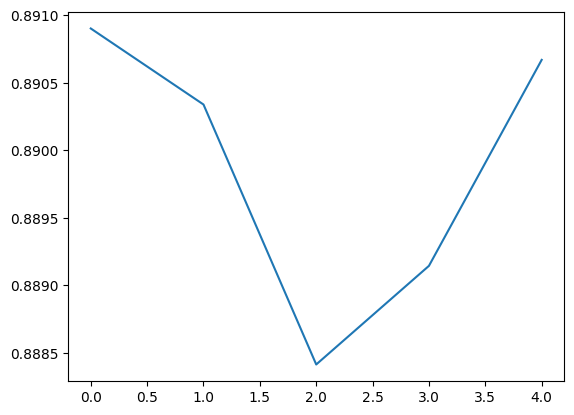

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
print(pqc_model.raw_params)

Parameter containing:
tensor([-1.4690, -0.0236, -1.8450,  2.6501,  0.8607, -2.4457,  2.8413,  0.1786,
        -2.9126, -0.1177, -0.3295, -0.2467,  1.8975,  0.0136,  1.0624],
       requires_grad=True)


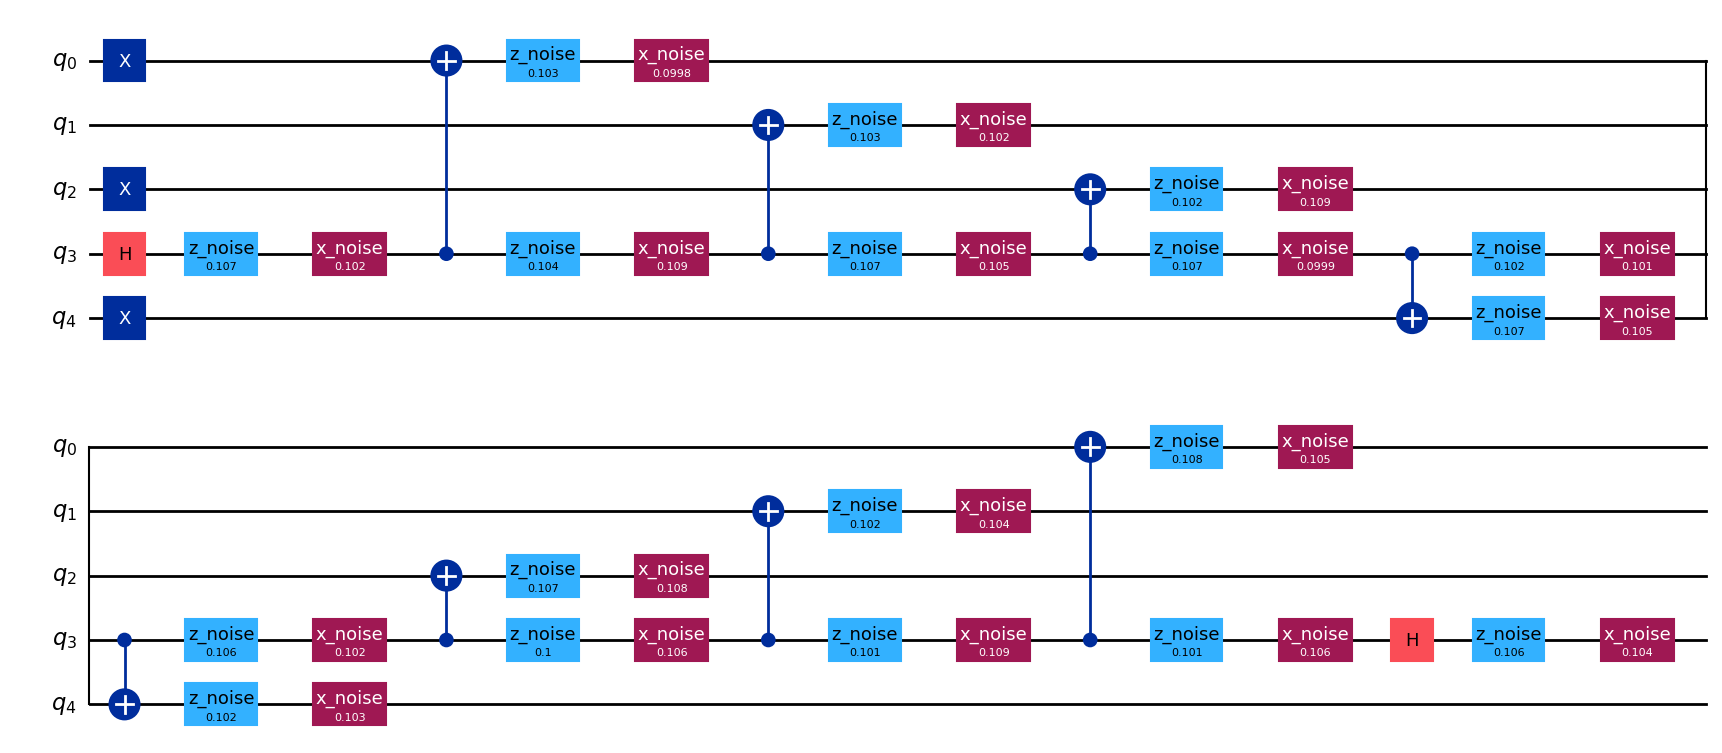

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

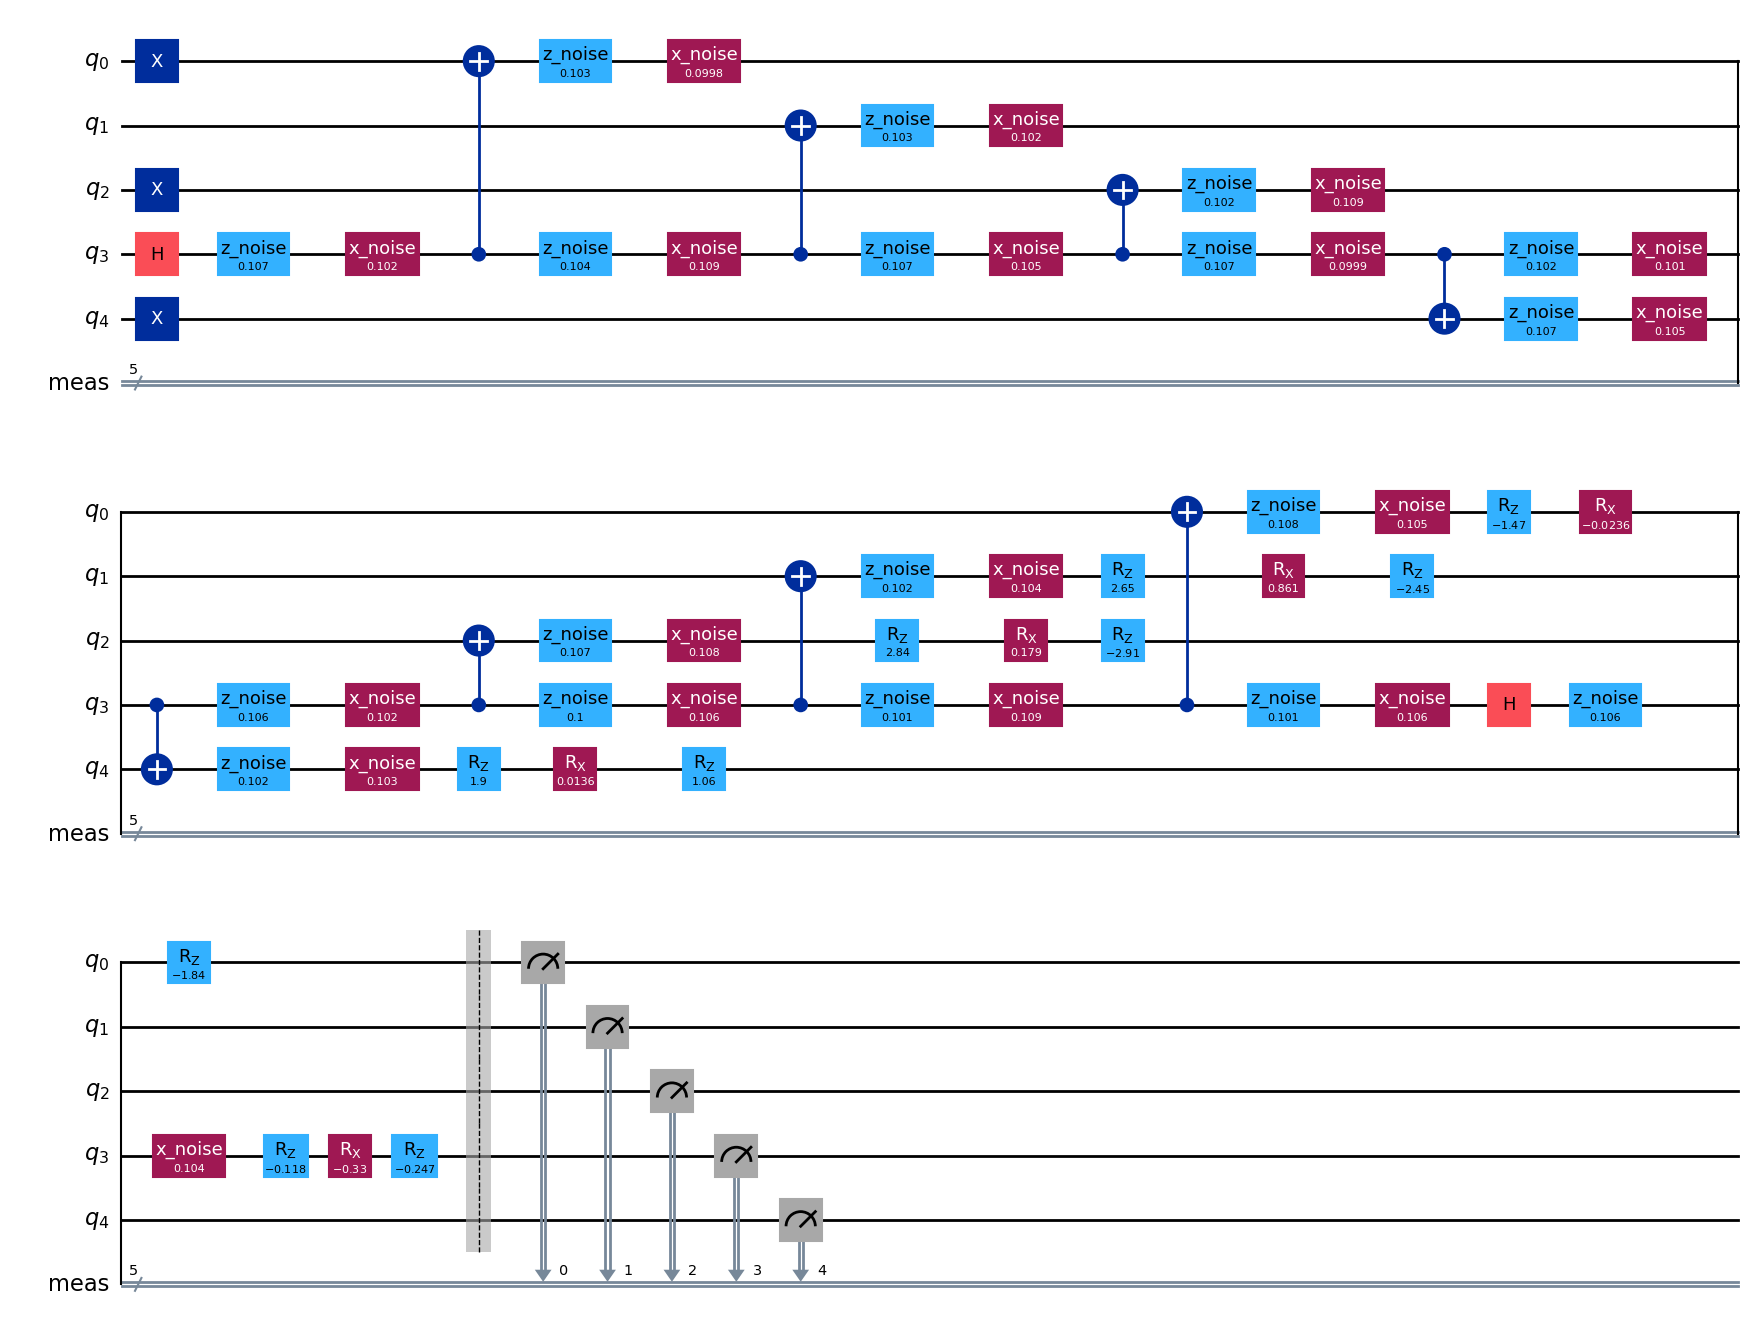

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, qiskit_PQC_RZRXRZ_unique)
noisy_model_circ_pqc.draw('mpl')

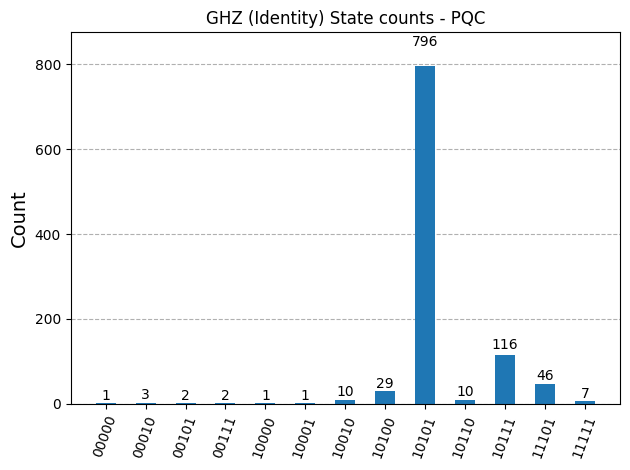

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

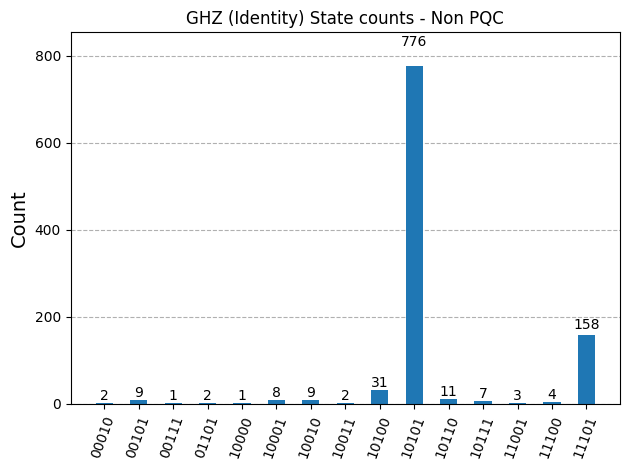

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

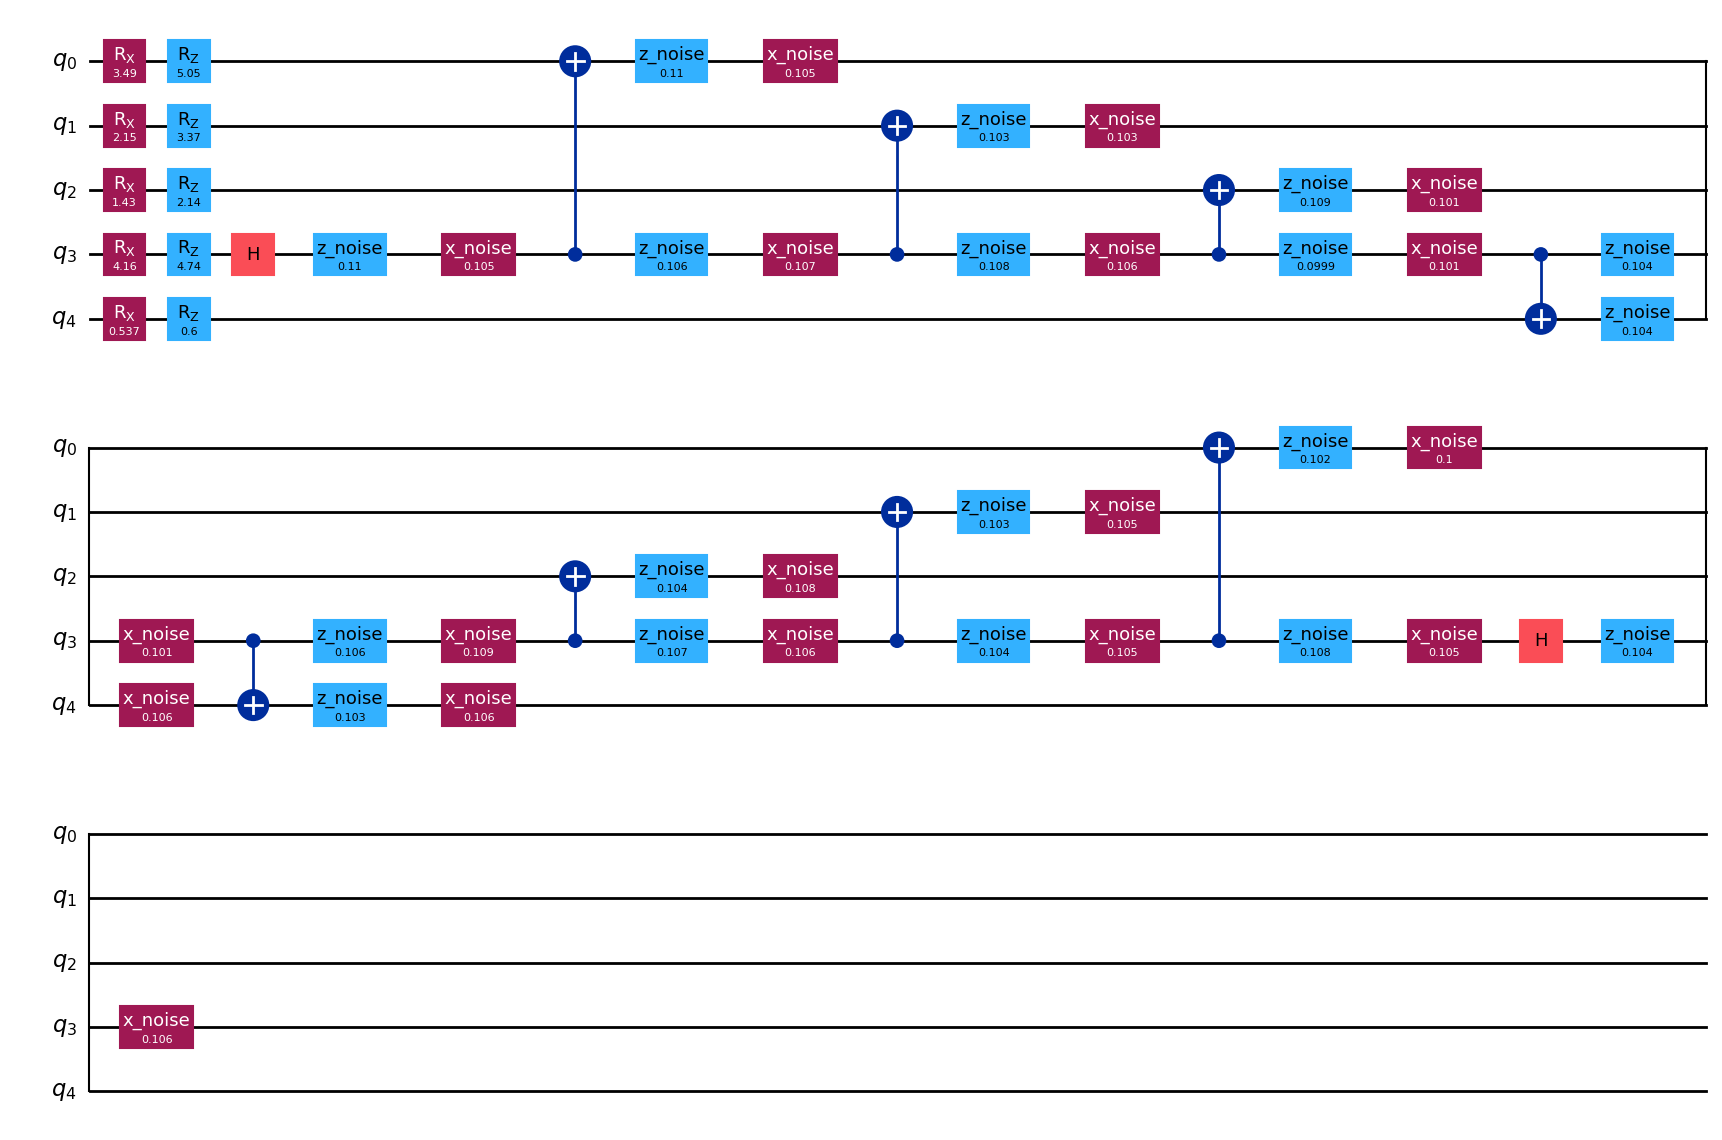

In [16]:
circuit.draw('mpl')

In [17]:
from qiskit.quantum_info import Statevector

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def state_fidelity(psi: torch.Tensor, phi: torch.Tensor) -> torch.Tensor:
    """
    Compute fidelity F = |⟨ψ|φ⟩|² between two normalized state vectors.

    Args:
        psi (torch.Tensor): Complex tensor of shape (2**n,) representing |ψ⟩
        phi (torch.Tensor): Complex tensor of shape (2**n,) representing |φ⟩

    Returns:
        torch.Tensor: Real-valued scalar fidelity
    """
    # Optional: normalize if needed
    psi = psi / torch.linalg.norm(psi)
    phi = phi / torch.linalg.norm(phi)

    overlap = torch.dot(torch.conj(psi), phi)
    return torch.abs(overlap) ** 2

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, num_vals=20, statevector=True)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, qiskit_PQC_RZRXRZ_unique)

    # counts_noisy = run_circuit_sampler(noisy_circ.measure_all(inplace=False))
    # counts_noisy_pqc = run_circuit_sampler(noisy_circ_pqc)

    # prob_i = counts_to_probs(ideal)
    # prob_n = counts_to_probs(counts_noisy)
    # prob_ne = counts_to_probs(counts_noisy_pqc)
    noi_out_st = torch.tensor(Statevector.from_instruction(noisy_circ.remove_final_measurements(inplace=False)).data)
    npqc_out_st = torch.tensor(Statevector.from_instruction(noisy_circ_pqc.remove_final_measurements(inplace=False)).data)
    
    

    fid_i_n = state_fidelity(ideal, noi_out_st)
    fid_i_ne = state_fidelity(ideal, npqc_out_st)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 1927.93it/s]


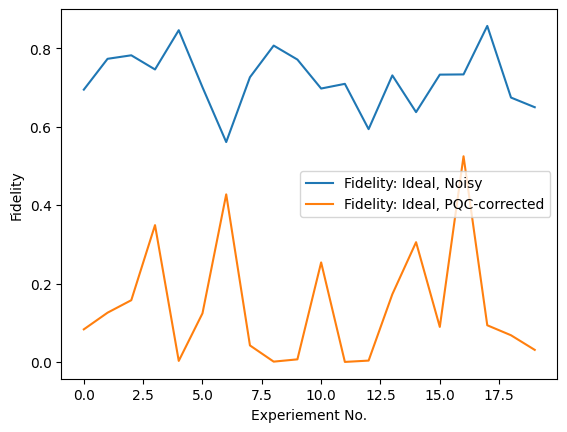

In [18]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [19]:
print(f"Avg Fidelity of noisy circuit: {np.mean(fid_noisy)}, Average Fidelity of noisy circ with PQC: {np.mean(fid_noisy_pqc)}")

Avg Fidelity of noisy circuit: 0.721093539174302, Average Fidelity of noisy circ with PQC: 0.14298225475525944


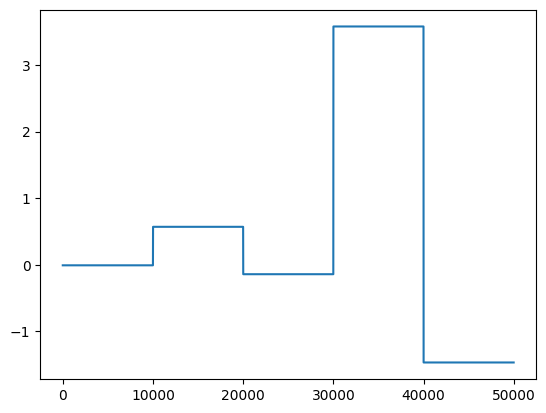

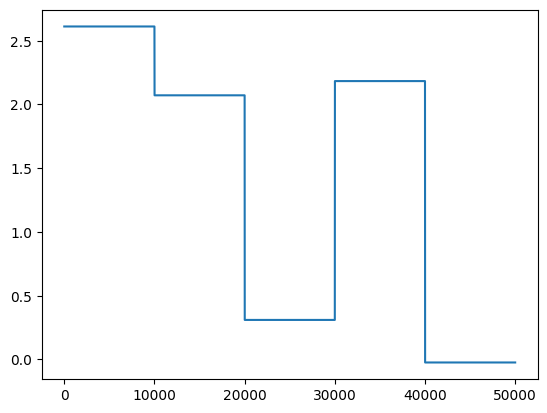

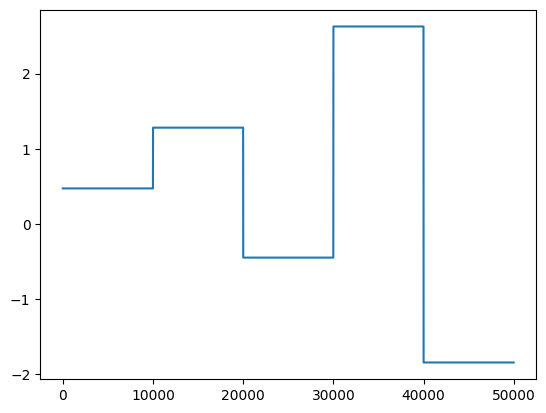

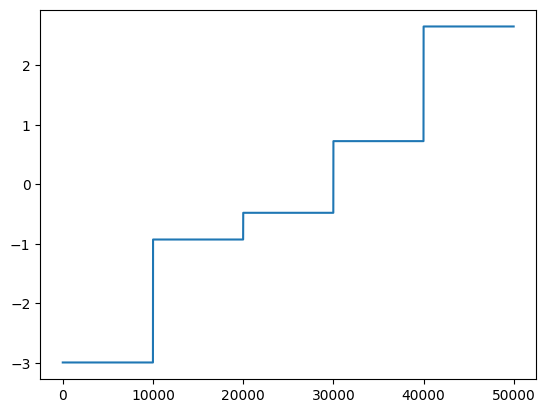

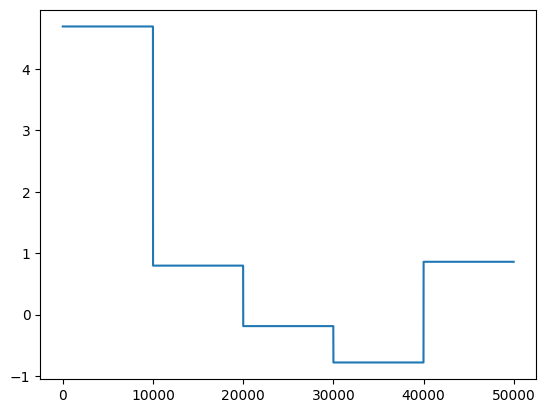

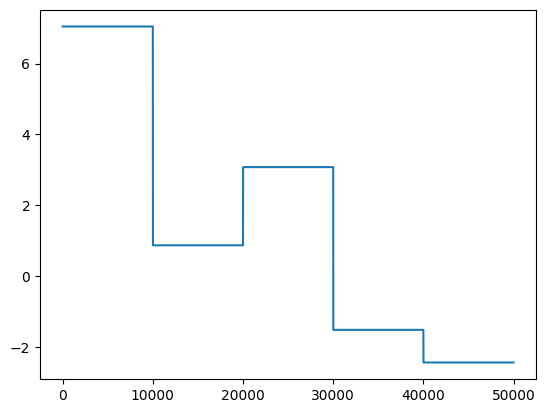

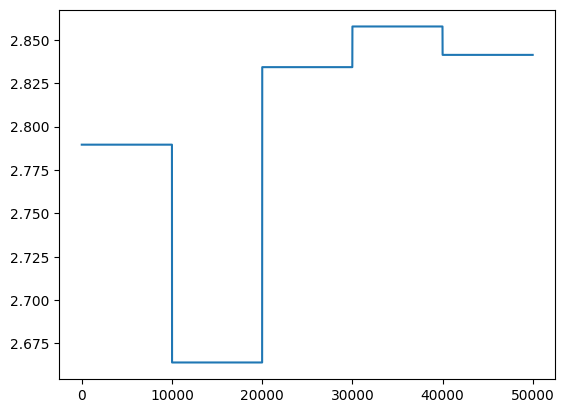

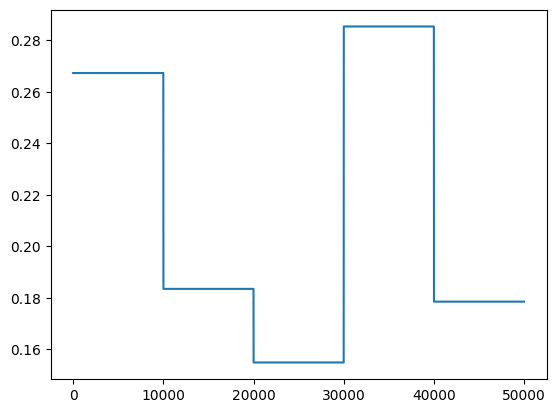

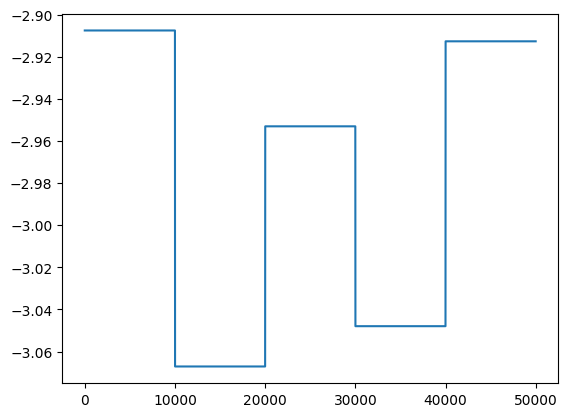

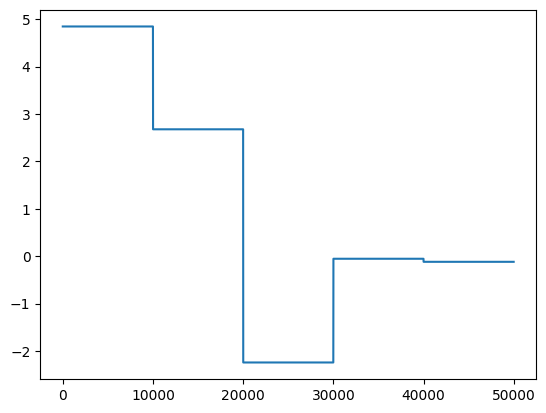

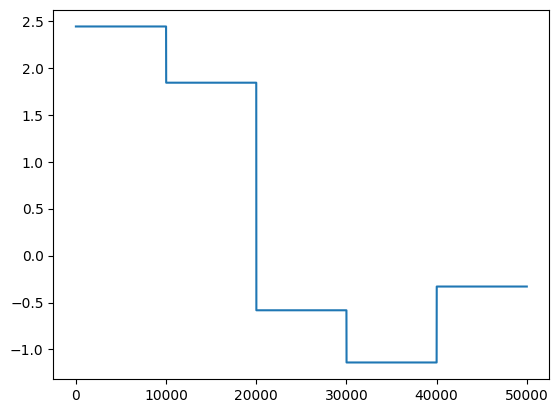

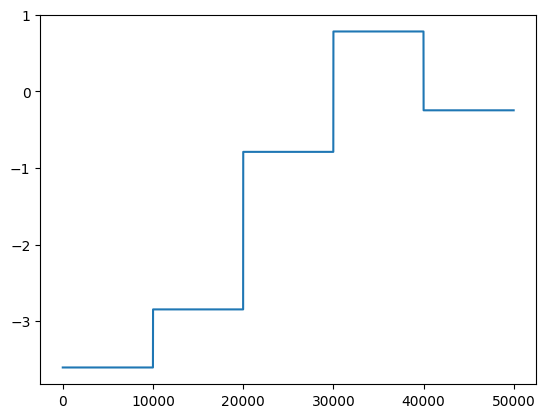

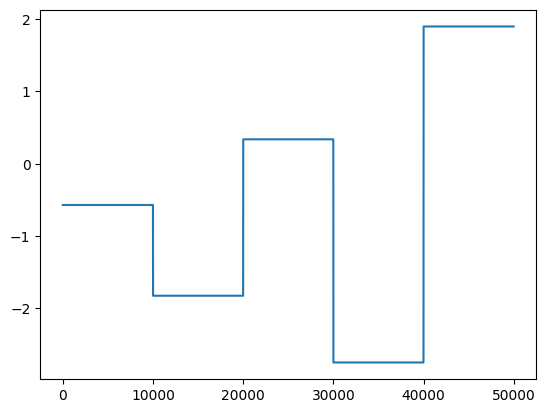

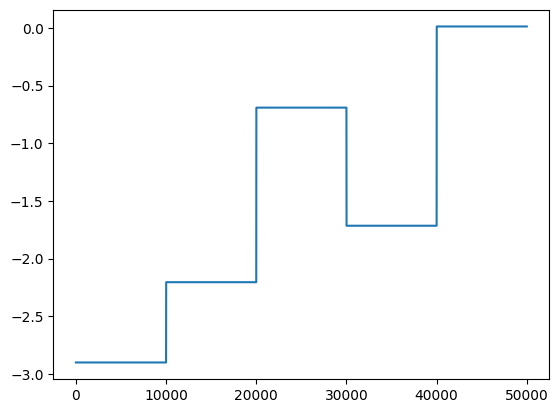

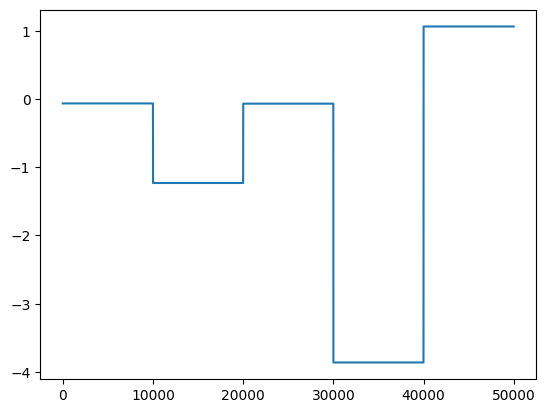

In [20]:
param_arr = np.array(param_list_epoch).transpose()
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()

In [21]:
print(ideal_data[0])

(array([[3.0260315 , 6.279686  ],
       [1.0361753 , 4.472371  ],
       [1.7489359 , 5.4237065 ],
       [5.475647  , 4.3329477 ],
       [2.7115898 , 0.66164833]], dtype=float32), tensor([ 2.5188e-03-0.0058j, -1.3829e-02-0.0254j,  8.3478e-05-0.0027j,
        -9.5057e-03-0.0079j, -6.8028e-03+0.0033j, -7.2953e-03+0.0338j,
        -2.1809e-03+0.0024j,  2.4541e-03+0.0146j, -6.1018e-04+0.0035j,
         1.1097e-02+0.0122j,  3.1911e-04+0.0015j,  6.3319e-03+0.0031j,
         3.3223e-03-0.0027j, -5.4110e-04-0.0197j,  8.8535e-04-0.0016j,
        -3.3330e-03-0.0077j, -1.0023e-01-0.0432j, -4.3807e-01+0.2406j,
        -4.6613e-02-0.0013j, -1.3577e-01+0.1648j,  5.7088e-02+0.1174j,
         5.8480e-01+0.1241j,  4.1235e-02+0.0376j,  2.5171e-01-0.0433j,
         6.1350e-02+0.0103j,  2.0995e-01-0.1926j,  2.5982e-02-0.0056j,
         5.2843e-02-0.1096j, -4.7518e-02-0.0573j, -3.4060e-01+0.0105j,
        -2.7921e-02-0.0152j, -1.3350e-01+0.0581j], dtype=torch.complex128))
